# Import

In [47]:
import matplotlib.pyplot as plt
import torch
from torch import FloatTensor, LongTensor
import math

In [48]:
from load_script_deep_framework import load_dataset

In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import torch.nn as nn

# Loading the dataset

In [51]:
train,target_train = load_dataset()

In [52]:
test,target_test = load_dataset()

0.3989422804014327


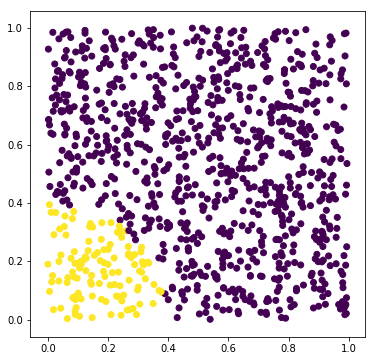

In [53]:
plt.figure(figsize=(6,6))
plt.scatter(test[:,0], test[:,1], c=target_test[:,1].numpy())

print(1/math.sqrt(2*math.pi))

# Generic Module Class

In [70]:
class Module():
    
    def forward(self,input):
        raise NotImplemented
        
    def backward(self,input):
        raise NotImplemented
            
    def param(self):
        return
    
    def __call__(self, *input):
        return self.forward(*input)
    
    def zero_grad_(self):
        return
    
    def update_weights_(self, learning_rate):
        return

# Specific classes

In [55]:
class Linear(Module):
    
    def __init__(self, input_features ,output_features):
        super(Linear,self).__init__()
        
        self._input_features = input_features
        self._output_features = output_features
    
        self._weights = torch.randn(self._output_features, self._input_features)*1e-1
        self._gradient = torch.zeros(self._weights.shape)
    
    def forward(self, input):
        self._input = input.view(-1)
        self._output = self._weights.mv(self._input)
        
        return self._output.clone()
        
    def backward(self, d_dy):
        self._gradient.add_(d_dy.view(-1,1)*self._input.view(1,-1))
        d_dx = self._weights.t().mv(d_dy)
        
        return d_dx
    
    def zero_grad_(self):
        self._gradient.zero_()
        
    def update_weights_(self, learning_rate):
        self._weights.add_(- learning_rate * self._gradient)
    

In [56]:
class ReLU(Module):
    
    def __init__(self):
        super(ReLU,self).__init__()
        
    def forward(self,input):
        self._input = input.clone()
        
        self._output = self._input.clone()
        self._output[self._output < 0] = 0

        return self._output.clone()
    
    def backward(self,d_dy):
        
        d_dx = d_dy.clone()
        d_dx[self._input < 0] = 0
        
        return d_dx
        

In [57]:
class Tanh(Module):
    def __init__(self):
        super(Tanh,self).__init__()
        
    def forward(self,input):
        self._input = input.clone()
        
        self._output = self._input.tanh()
        
        return self._output.clone()
    
    def backward(self,d_dy):
        d_dx= (1 - self._input.tanh()**2) * d_dy
        
        return d_dx
        

In [58]:
class LossMSE(Module):
    def __init__(self):
        super(LossMSE,self).__init__()
        
    def forward(self, input, target):
        self._input = input - target
        self._output = (self._input).pow(2).sum()
        return self._output
        
    def backward(self):
        d_dy = 2 * self._input
        return d_dy

In [75]:
class Sequential(Module):
    def __init__(self, modules ,loss):
        super(Sequential,self).__init__()
        
        self._modules = modules
        self._loss = loss
    
    def forward(self, input, target):
        
        y = input.clone()
        for module in self._modules:
            y = module(y)
        
        output = y.clone()
        
        loss = self._loss(y, target)
        
        return loss, output
    
    def backward(self):
        d_dy = self._loss.backward()
        
        for module in reversed(self._modules):
            d_dy = module.backward(d_dy)
            
            
    def zero_grad_(self):
        for module in self._modules:
            module.zero_grad_()

    def update_weights_(self,learning_rate):
        for module in self._modules:
            module.update_weights_(learning_rate)

In [93]:
# Define Neural Network
layers = [
    Linear(2,25),
    ReLU(),
    Linear(25,25),
    ReLU(),
    Linear(25,25),
    ReLU(),
    Linear(25,2),
    Tanh()
]

loss = LossMSE()

learning_rate = 1e-3

network = Sequential(layers, loss)

num_epochs = 10

for epoch in range(num_epochs):
    
    correct = 0
    all_output = []

    for j, pair in enumerate(zip(train,target_train)):
        
        # Load sample
        train_element, target_element = pair
        
        # Forward pass
        loss, output = network(train_element, target_element)

        # Backward pass, gradient step and reinitalize gradient
        network.backward()
        network.update_weights_(learning_rate)
        network.zero_grad_()

        # Training error
        boolean_target = target_element[1] > target_element[0]
        boolean_output = output[1] > output[0]
        
        all_output.append(output)
        
        #difference = abs(output[1] - output[0])
        #boolean_output = difference < 1
        if boolean_target == boolean_output:
            correct += 1

    print('Epoch: {}. Error rate: {} %'.format(epoch ,(1000-correct)/1000*100))

Epoch: 0. Error rate: 14.000000000000002 %
Epoch: 1. Error rate: 14.000000000000002 %
Epoch: 2. Error rate: 14.000000000000002 %
Epoch: 3. Error rate: 14.000000000000002 %
Epoch: 4. Error rate: 14.000000000000002 %
Epoch: 5. Error rate: 14.000000000000002 %
Epoch: 6. Error rate: 14.000000000000002 %
Epoch: 7. Error rate: 14.000000000000002 %
Epoch: 8. Error rate: 14.000000000000002 %
Epoch: 9. Error rate: 14.000000000000002 %


In [94]:
all_output

[
  0.3319
 -0.3348
 [torch.FloatTensor of size 2], 
  0.9146
 -0.9169
 [torch.FloatTensor of size 2], 
  0.8592
 -0.8598
 [torch.FloatTensor of size 2], 
  0.7196
 -0.7248
 [torch.FloatTensor of size 2], 
  0.7945
 -0.7993
 [torch.FloatTensor of size 2], 
  0.8351
 -0.8387
 [torch.FloatTensor of size 2], 
  0.7516
 -0.7533
 [torch.FloatTensor of size 2], 
  0.9574
 -0.9582
 [torch.FloatTensor of size 2], 
  0.9577
 -0.9588
 [torch.FloatTensor of size 2], 
  0.2915
 -0.2929
 [torch.FloatTensor of size 2], 
  0.3353
 -0.3355
 [torch.FloatTensor of size 2], 
  0.7894
 -0.7916
 [torch.FloatTensor of size 2], 
  0.5065
 -0.5088
 [torch.FloatTensor of size 2], 
  0.3871
 -0.3890
 [torch.FloatTensor of size 2], 
  0.7974
 -0.7992
 [torch.FloatTensor of size 2], 
  0.5688
 -0.5726
 [torch.FloatTensor of size 2], 
  0.7791
 -0.7841
 [torch.FloatTensor of size 2], 
  0.9661
 -0.9668
 [torch.FloatTensor of size 2], 
  0.4988
 -0.5034
 [torch.FloatTensor of size 2], 
  0.7949
 -0.7946
 [torch.Flo

# Test

In [91]:
correct = 0

for j, pair in enumerate(zip(test,target_test)):

    # Load test sample
    test_element, target_test_element = pair
    
    # Forward pass
    loss, output = network(test_element,target_test_element)
        
    boolean_target = target_test_element[1] > target_test_element[0]
    
    difference = abs(output[1]-output[0])
    boolean_output = difference < 1
    
    if boolean_target == boolean_output:
        correct += 1
    
    if j % 100 == 0:
        print('Iteration: {}. Error rate {} %'.format(j, (1000-correct)/1000 * 100))

Iteration: 0. Error rate 100.0 %
Iteration: 100. Error rate 90.4 %
Iteration: 200. Error rate 80.80000000000001 %
Iteration: 300. Error rate 71.1 %
Iteration: 400. Error rate 61.5 %
Iteration: 500. Error rate 51.800000000000004 %
Iteration: 600. Error rate 42.4 %
Iteration: 700. Error rate 32.5 %
Iteration: 800. Error rate 22.7 %
Iteration: 900. Error rate 13.0 %
